## **Movies on a Plane**

# Business Understanding

Here at ABC Airlines we are happy to provide the perk of movies in air during our flights.  But, as our library of movies is paid for by licensing, not views, and the cost is getting too high, we have been tasked to limit the movies available on a flight.  Concurrently, our userface will change and passengers will not simply type in a movie name, but we will recommend movies based on their prior movie ratings.

# Data Understanding

Data provided by MovieLens, a movie recommendation service, provides us with an individuals userID, list of seen movies and a user-specific rating for each of those movies.  This data is provided for all 610 passengers on our flight.

Each movie is rated on a 5-star scale.  The total rated movies amongst the 610 passengers is nearly 10,000 movies.

In [1]:
# pip install --force-reinstall numpy==1.24.3

In [2]:
!pip install scikit-surprise

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ndcg_score
from surprise import accuracy
import warnings
warnings.filterwarnings('ignore')

In [4]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

movie_ratings = pd.merge(ratings, movies,on='movieId')
movie_ratings = movie_ratings.drop(columns=['timestamp'])
movie_ratings.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [5]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   title    100836 non-null  object 
 4   genres   100836 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 3.8+ MB


In [6]:
movie_ratings.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


## Data Preparation

In a first step to make good recommendations, we remove any movie that has less than 5 reviews.  Then, we normalize our ratings by using the mean rates for each user.  Using the normalized ratings, we come up with a list of the 1,500 highest rated moves that will be our available movie set ready for recommending.  This reduces the movies we have available from nearly 10,000 to 1,500 based on their ratings.

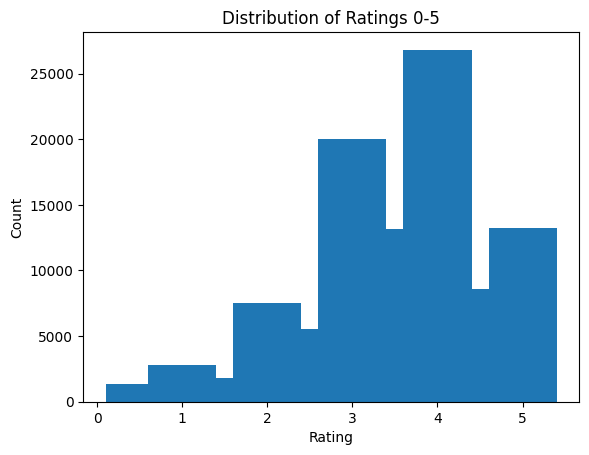

In [7]:
rating_counts = movie_ratings['rating'].value_counts()
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings 0-5')
plt.show()

In [8]:
movie_ratings['title'].value_counts()

,count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
...,...
"Sex, Drugs & Taxation (2013)",1
Extraordinary Tales (2015),1
Tomorrow (2015),1


In [9]:
# remove movies that have less than 5 reviews
review_counts = movie_ratings['title'].value_counts()
movie_ratings = movie_ratings[movie_ratings['title'].isin(review_counts[review_counts >= 5].index)]
movie_ratings['title'].value_counts()

,count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
...,...
Agent Cody Banks (2003),5
"Sorry, Wrong Number (1948)",5
"War, The (1994)",5


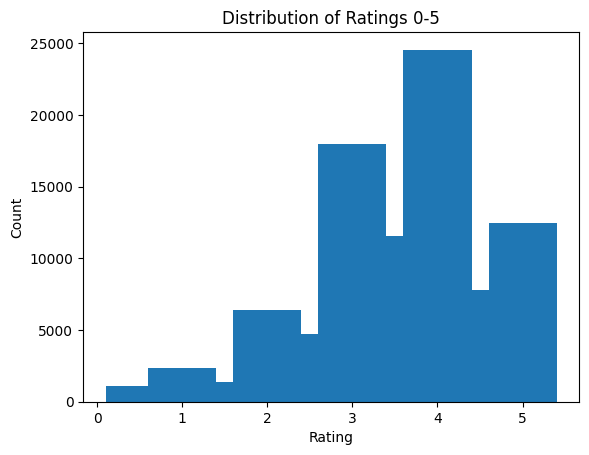

In [10]:
rating_counts = movie_ratings['rating'].value_counts()
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings 0-5')
plt.show()

In [11]:
movie_ratings

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
100830,610,166528,4.0,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi
100831,610,166534,4.0,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,Get Out (2017),Horror


In [12]:
# did need to normalize the ratings here in order to rank them for a top 1500
user_means = movie_ratings.groupby('userId')['rating'].mean()
normalized_ratings = movie_ratings.copy()
normalized_ratings['normalized_rating'] = movie_ratings['rating'] - user_means[movie_ratings['userId']].values
normalized_ratings

,userId,movieId,rating,title,genres,normalized_rating
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,-0.361233
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,-0.361233
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,-0.361233
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0.638767
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0.638767
...,...,...,...,...,...,...
100830,610,166528,4.0,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi,0.240486
100831,610,166534,4.0,Split (2017),Drama|Horror|Thriller,0.240486
100832,610,168248,5.0,John Wick: Chapter Two (2017),Action|Crime|Thriller,1.240486
100833,610,168250,5.0,Get Out (2017),Horror,1.240486


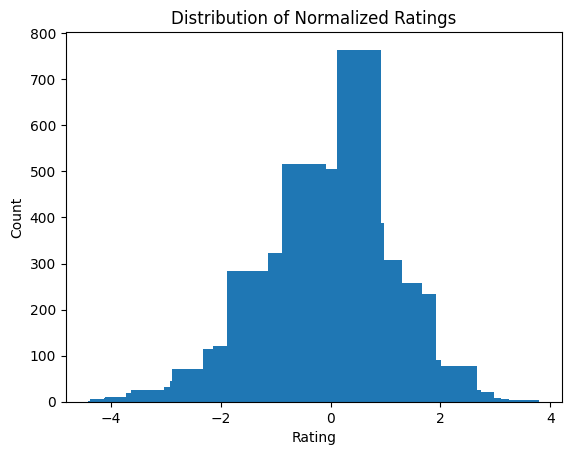

In [13]:
normalize_rating_counts = normalized_ratings['normalized_rating'].value_counts()
plt.bar(normalize_rating_counts.index, normalize_rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Normalized Ratings')
plt.show()

In [14]:
average_rating = normalized_ratings.groupby('title')['normalized_rating'].mean()
top1500_ratings = average_rating.sort_values(ascending=False).head(1497)

top1500_movies = pd.merge(top1500_ratings, movies,on='title')
top1500_movies = top1500_movies['movieId']
top1500_movies

,movieId
0,27156
1,106642
2,158966
3,3266
4,51931
...,...
1495,799
1496,2413
1497,30810
1498,1019


# Modeling

To model the recommendations, singular value decomposition (SVD) is a collaborative filtering which is the process of making recommendations based on the preferences of other similar users.  We utilize SVD by creating a matrix of rows representing each user and columns for each movie - with ratings, if reviewed, in the matrix.  Using GridSearchCV, we tuned the parameters of the SVD model to confirm we were using the best model. We train our model on 70% of our total dataset.

In [15]:
user_ratings_matrix = movie_ratings.pivot_table(index='userId', columns='title', values='rating')
user_ratings_matrix.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),102 Dalmatians (2000),12 Angry Men (1957),...,Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),[REC] (2007),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(movie_ratings[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

In [17]:
#param_grid = {'n_factors': [25, 50, 100, 150],'n_epochs': [20, 30, 40],'reg_all': [0.02, 0.05, 0.1],'lr_all': [0.005, 0.01, 0.05]}
#gs = GridSearchCV(SVD,param_grid,measures=['rmse'],cv=5,n_jobs=-1)
#gs.fit(data)

#print(gs.best_params['rmse'])
#print(gs.best_score['rmse'])

In [18]:
model=SVD()
model.fit(trainset)

In [19]:
model_bestparam=SVD(n_factors=150, n_epochs=40, reg_all=0.1, lr_all=0.01)
model_bestparam.fit(trainset)

# Evaluation

After fitting the model to our training dataset, we run the model with our testing dataset.  Those predictions are compared to the actual testing dataset.  An RMSE of 0.8595 tells us that for a predicted rating, the real rating for that user and that movie, is within .8595.  While this is close to a point, it is generally considered a good score on a 5 point rating system.  Therfore, our model is a good predictor of ratings.

The SVD model we ran with the best parameters as decided with the GridSearchCV model, dropped that RMSE to .8381.

While RMSE is a good predictor of the model, we also used a Normalized Cumulative Gain (NDCG) score to evaluate the SVD model.  The NDCG of .988 is very high and means that the recommendations provided to the passengers are a very good fit.

In [20]:
predictions = model.test(testset)

In [21]:
predictions_bestparam = model_bestparam.test(testset)

In [22]:
accuracy_svd = accuracy.rmse(predictions)

RMSE: 0.8592


In [23]:
accuracy_SVD_bestparam = accuracy.rmse(predictions_bestparam)

RMSE: 0.8370


In [34]:
true_ratings = {}
for userID, movieID, actualRating, in testset:
    if userID not in true_ratings:
        true_ratings[userID] = []
    true_ratings[userID].append((movieID, actualRating))

predicted_ratings = {}
for userID, movieID, actualRating, estimatedRating, _ in predictions:
    if userID not in predicted_ratings:
        predicted_ratings[userID] = []
    predicted_ratings[userID].append((movieID, estimatedRating))

true = np.array([rating for ratings in true_ratings.values() for _, rating in ratings])
predicted = np.array([rating for ratings in predicted_ratings.values() for _, rating in ratings])

ndcg = ndcg_score([true], [predicted])
ndcg

0.988163071414687

Using those predicted ratings, we rank the unwatched movies per user. The first top 5 recommended movies, that are also in the set of 1,500 that we have narrowed our library down to, are recommended to the user.

In [25]:
def get_recommendations(predictions, n=5):
    recommendations = {}
    for userID, movieID, actualRating, estimatedRating, _ in predictions:
        if movieID in top1500_movies:
          if userID not in recommendations:
            recommendations[userID] = []
          recommendations[userID].append((movieID, estimatedRating))

    for userID, ratings in recommendations.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        recommendations[userID] = ratings[:n]

    return recommendations

In [26]:
top_5 = get_recommendations(predictions,n=5)

In [27]:
top_5_bestparam = get_recommendations(predictions_bestparam,n=5)

In [28]:
userID_input = 256

if userID_input in top_5:
  print(f"Top SVD recommendations for user {userID_input}:")
  for movie_id, estimated_rating in top_5[userID_input]:
    movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
    print(f"- {movie_title} (Estimated rating: {estimated_rating:.2f})")
else:
    print(f"No recommendations found for user {userID_input}.")

print(f"\n")

if userID_input in top_5_bestparam:
  print(f"Top SVD Best Parameters recommendations for user {userID_input}:")
  for movie_id, estimated_rating in top_5_bestparam[userID_input]:
    movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
    print(f"- {movie_title} (Estimated rating: {estimated_rating:.2f})")
else:
  print(f"No recommendations found for user {userID_input}.")


Top SVD recommendations for user 256:
- Silence of the Lambs, The (1991) (Estimated rating: 4.56)
- Star Wars: Episode V - The Empire Strikes Back (1980) (Estimated rating: 4.45)
- Desperado (1995) (Estimated rating: 4.08)
- Independence Day (a.k.a. ID4) (1996) (Estimated rating: 3.91)
- Speed (1994) (Estimated rating: 3.91)


Top SVD Best Parameters recommendations for user 256:
- Star Wars: Episode V - The Empire Strikes Back (1980) (Estimated rating: 4.37)
- Silence of the Lambs, The (1991) (Estimated rating: 4.22)
- Speed (1994) (Estimated rating: 4.18)
- Independence Day (a.k.a. ID4) (1996) (Estimated rating: 4.10)
- Desperado (1995) (Estimated rating: 4.10)


In [29]:
userID_input = 256

In [30]:
recommendations_count = {}
for user_id, recommendations in top_5.items():
    recommendations_count[user_id] = len(recommendations)

recommendation_counts = pd.Series(recommendations_count)
recommendation_counts.value_counts()

,count
5,420
2,54
3,52
4,33
1,31


# Conclusion

Using a model to recommend movies to the passengers on our flights allows us to cut the cost of this service by only offering a subset of movies, while continuing to provide highly rated movies that fit with the passengers preferences.

# Limitations and Next Steps

The largest limitation to a recommendation model is the cold start problem.  While we have completed this analysis assuming we have the movie preferences and ratings of all passengers on our flights, it is not practical.  Without those to begin with, our model is at a loss.  One way to address this problem is using demographic data.  A passenger's information such as age and gender may connect them to users already in the data.